In [1]:
# Change the dataset in global_vars.py to KORA.
from global_vars import *
from commons import *

import glob 
import os

one_time_n4_optimization = True
vol_to_check_list = None # ['KORA2460830', 'KORA2460249']
exclude = ['KORA2460249']

%load_ext autoreload
%autoreload 2

In [ ]:
# os.listdir(label_dir)

In [ ]:
def load_kora_file_paths(load_from_txt_file=True):
    volumes_to_use = []
    if load_from_txt_file:
        with open(volume_txt_file) as file_handle:
                volumes_to_use = file_handle.read().splitlines()
    else:
        volumes_to_use = [name for namelabel in os.listdir(data_dir)]
    
    file_paths = {}
    
    for vol in volumes_to_use:
        if (vol_to_check_list is not None and vol not in vol_to_check_list) or (vol == "") or (vol in exclude):
            continue
            
        labelmap_paths = glob.glob(f'{label_dir}/{vol}/**')
        opp_paths = glob.glob(f'{data_dir}/{vol}/**opp_[0-9]**.nii.gz')
        in_paths = glob.glob(f'{data_dir}/{vol}/**in_[0-9]**.nii.gz')
        f_paths = glob.glob(f'{data_dir}/{vol}/**F_[0-9]**.nii.gz')
        w_paths = glob.glob(f'{data_dir}/{vol}/**W_[0-9]**.nii.gz')
        
        vol_madals_paths = dict(
        OPP=opp_paths,
        IN=in_paths,
        F=f_paths,
        W=w_paths
        )
        file_paths[str(vol)]=dict(
            VOLUME_PATHS=vol_madals_paths,
            LABEL_PATHS=labelmap_paths,
        )
    return file_paths

file_paths = load_kora_file_paths()
file_paths

In [ ]:
# Individual RESCALING.
n4_dict = {}
for vol in file_paths.keys():
    if one_time_n4_optimization:
        break
    print(f'n4 processing part-1 started with {vol}...')
    n4_dict[vol] = []
    vol_parts = [[file, read_ras(file)] for file in file_paths[vol]['VOLUME_PATHS']['IN']]
    for orig_file, in_image in vol_parts:
        n4_dict[vol].append(rescale(in_image, vol, orig_file))

In [ ]:
# SITK does ot work due to differences in pixel resolution of IN and corresponding OPP Scan.
# Only applying once at the end.
for vol in file_paths.keys():
    if one_time_n4_optimization:
        break
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    print(f'n4-biasfield-correction starting with {vol}...')
    for idx, n4_d in enumerate(n4_dict[vol]):
        in_file = n4_d['SCALED']
        opp_file = file_paths[vol]['VOLUME_PATHS']['OPP'][idx]
        new_filename = opp_file.split('/')[-1].split('.')[0]
        output_file = f'{n4_corrected_data_dir}/vol/{vol}/{new_filename}_n4_corrected_sitk.nii.gz'
        SITK_N4_normalization(in_file, opp_file, output_file)
        n4_dict[vol][idx]['OPP_CORRECTED'] = output_file

    file_paths[vol]['N4_1'] = n4_dict[vol]

In [ ]:
# STITCHING VOL PARTS HERE
for vol in file_paths.keys():
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    print(f'started with {vol}...')
    create_if_not(f'{n4_corrected_data_dir}/vol/{vol}')
    file_paths[vol]['ONE'] = {}
    for modality_key in file_paths[vol]['VOLUME_PATHS'].keys():
        print(f"processing {modality_key}")
        orig_modal_key = modality_key
        if one_time_n4_optimization:
            vol_parts = [read_ras(file) for file in file_paths[vol]['VOLUME_PATHS'][modality_key]]
        else:
            if modality_key == 'OPP':
                vol_parts = [read_ras(data_dict['OPP_CORRECTED']) for data_dict in file_paths[vol]['N4_1']]
                modality_key = modality_key+'_n4_corrected'
            else:
                vol_parts = [read_ras(file) for file in file_paths[vol]['VOLUME_PATHS'][modality_key]]

        ras_stitched_resampled = multi_vol_stitching(vol_parts)
        save_volume(ras_stitched_resampled, f'{n4_corrected_data_dir}/vol/{vol}/{modality_key}_ras_stitched')
        file_paths[vol]['ONE'][f'{orig_modal_key}'] = f'{n4_corrected_data_dir}/vol/{vol}/{modality_key}_ras_stitched.nii.gz'

In [ ]:
# RESCALING INTENSITIES OF STITCHED VOLUME ABOVE 0
n4_dict = {}
for vol in file_paths.keys():
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    print(f'n4 processing part-2 started with {vol}...')
    n4_dict[vol] = {}
    in_stitched_file_path, in_stitched_img = file_paths[vol]['ONE']['IN'], read_ras(file_paths[vol]['ONE']['IN'])
    n4_dict[vol]['N4_2'] = rescale(in_stitched_img, vol, in_stitched_file_path)

In [ ]:
for vol in file_paths.keys():
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    print(f'n4-biasfield-correction starting with {vol}...')
    in_file = n4_dict[vol]['N4_2']['SCALED']
    opp_file = file_paths[vol]['ONE']['OPP']
    new_filename = opp_file.split('/')[-1].split('.')[0]
    output_file = f'{n4_corrected_data_dir}/vol/{vol}/{new_filename}_n4_corrected_sitk.nii.gz'
    SITK_N4_normalization(in_file, opp_file, output_file)
    n4_dict[vol]['N4_2']['OPP_CORRECTED'] = output_file
    file_paths[vol]['N4_2'] = n4_dict[vol]['N4_2']

In [4]:
def kora_vol_label_fix(vol, label, use_alternate_approach=False):
    world_shape = np.max(np.array([list(vol.shape), list(label.shape)]), axis=0)
    final_label = np.zeros(tuple(world_shape))
    
    label_affine = label.affine
    vol_affine = vol.affine
    target_affine = vol_affine
    target_header = vol.header

    sx,sy,sz,ex,ey,ez = np.abs(get_points(label, vol))

    ld = label.get_fdata()
    if not use_alternate_approach:
        final_label[0:sx+ex, 0:sy+ey, 0:sz+ez] = ld
    else:
        final_label[0:sx+ex, 0:sy+ey, 77:77+76] = ld[:, :, :76]
        
    final_label = np.flip(final_label, axis=0)
    final_label = np.flip(final_label, axis=2)
    
    final_label_img = nb.Nifti1Image(final_label, target_affine, target_header)
    
    return vol, final_label_img

def kora_label_parts(label_parts, reference_labelmap=None):
    stitched_label = None
    mode = 'constant'
    order = 0
    if reference_labelmap is None:
        label_shape = get_freequent_shape([img.shape for img, _, _ in label_parts])
        reference_labelmap = [img for img, _, _ in label_parts if list(img.shape) == list(label_shape)][0]
    else:
        label_shape = reference_labelmap.shape
        
    stitched_label = np.zeros(label_shape)
    for labelmap_img, lidx, lname in label_parts:
        print(lidx, lname)
        labelmap_img = makeit_3d(labelmap_img)
        labelmap_img = resample_from_to(labelmap_img, [label_shape, reference_labelmap.affine], order=order, mode=mode, cval=0)
        
        sx,sy,sz,ex,ey,ez = np.abs(get_points(labelmap_img, reference_labelmap))
        
        labelmap = labelmap_img.get_fdata()
        labelmap = np.multiply(lidx, labelmap)
        stitched_label[0:ex+sx, 0:ey+sy, 0:ez+sz] += labelmap
        
        print("###############################################################################################") 
        
    labelmap = np.round(stitched_label)
    stitched_labeled_img = nb.Nifti1Image(labelmap, reference_labelmap.affine, reference_labelmap.header)
    
    return stitched_labeled_img

In [ ]:
# import pickle as p
# with open('new_oksana_kora_file_paths.p', 'wb') as handle:
#     p.dump(file_paths, handle, protocol=p.HIGHEST_PROTOCOL)

In [5]:
# import pickle as p
# with open('new_oksana_kora_file_paths.p', 'rb') as handle:
#     file_paths = p.load(handle)

STARTING KORA LABEL-MAPS.
Reading Label Maps.....
KORA2459728
KORA2453290
KORA2460408
KORA2452879
KORA2458366
KORA2453363
KORA2456120
KORA2460734
KORA2459745
KORA2462026
['datasets/lablmaps/KORA/KORA2462026/2462026_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm_rescaled_applied_in_bias_corrected_Kidney(links).nrrd', 'datasets/lablmaps/KORA/KORA2462026/2462026_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm_rescaled_applied_in_bias_corrected_Liver.nrrd', 'datasets/lablmaps/KORA/KORA2462026/2462026_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm_rescaled_applied_in_bias_corrected_Pancreas.nrrd', 'datasets/lablmaps/KORA/KORA2462026/2462026_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm_rescaled_applied_in_bias_corrected_Adrenal gland(right).nrrd', 'datasets/lablmaps/KORA/KORA2462026/2462026_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm_rescaled_applied_in_bias_corrected_Adrenal gland(links).nrrd', 'datasets/lablmaps/KORA/KORA

Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/KORA/KORA2462026/2462026_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED_ADRENALGLAND(LINKS).NRRD
[False] False
LIVER DATASETS/LABLMAPS/KORA/KORA2462026/2462026_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED_ADRENALGLAND(LINKS).NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/KORA/KORA2462026/2462026_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED_ADRENALGLAND(LINKS).NRRD
SPL DATASETS/LABLMAPS/KORA/KORA2462026/2462026_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED_ADRENALGLAND(LINKS).NRRD
[False, False] False
KIDNEY_R DATASETS/LABLMAPS/KORA/KORA2462026/2462026_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED_ADRENALGLAND(LINKS).NRRD
KIDNEY(RIGHT) DATASETS/LABLMAPS/KORA/KORA2462026/2462026_T1_VIBE_DI

104 KIDNEY(LEFT)
###############################################################################################
101 LIVER
###############################################################################################
105 ADRENALGLAND
###############################################################################################
105 ADRENALGLAND
###############################################################################################
103 KIDNEY(RIGHT)
###############################################################################################
102 SPLEEN
###############################################################################################
107 GALLBLADDER
###############################################################################################
106 PANCREAS
###############################################################################################
Overlapped Idxs Found, removing it for idx 0.0
Overlapped Idxs Found, removing it for idx 204.0
Overlapped Idxs F

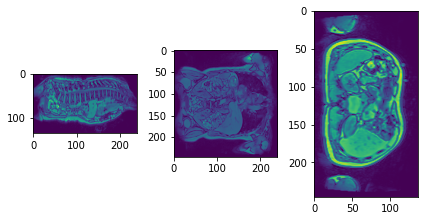

Affine:[[   2.            0.           -0.         -245.71185303]
 [   0.            2.           -0.         -155.94158936]
 [   0.            0.            3.         -729.93225098]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


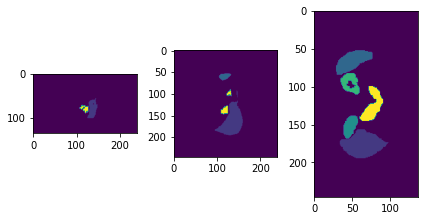

Saving Processed & Stitched Image.....
saving directory: temp/KORA/processed/volume
saving directory: temp/KORA/processed/label
KORA2462405
['datasets/lablmaps/KORA/KORA2462405/2462405_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm_rescaled_applied_in_bias_corrected_Liver.nrrd', 'datasets/lablmaps/KORA/KORA2462405/2462405_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm_rescaled_applied_in_bias_corrected_Adrenal gland(right).nrrd', 'datasets/lablmaps/KORA/KORA2462405/2462405_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm_rescaled_applied_in_bias_corrected_Pancreas.nrrd', 'datasets/lablmaps/KORA/KORA2462405/2462405_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm_rescaled_applied_in_bias_corrected_Adrenal gland(left).nrrd', 'datasets/lablmaps/KORA/KORA2462405/2462405_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm_rescaled_applied_in_bias_corrected_Kidney(left).nrrd', 'datasets/lablmaps/KORA/KORA2462405/2462405_t1_vibe_dixon_co

Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/KORA/KORA2462405/2462405_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED_ADRENALGLAND(LEFT).NRRD
[False] False
LIVER DATASETS/LABLMAPS/KORA/KORA2462405/2462405_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED_ADRENALGLAND(LEFT).NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/KORA/KORA2462405/2462405_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED_ADRENALGLAND(LEFT).NRRD
SPL DATASETS/LABLMAPS/KORA/KORA2462405/2462405_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED_ADRENALGLAND(LEFT).NRRD
[False, False] False
KIDNEY_R DATASETS/LABLMAPS/KORA/KORA2462405/2462405_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED_ADRENALGLAND(LEFT).NRRD
KIDNEY(RIGHT) DATASETS/LABLMAPS/KORA/KORA2462405/2462405_T1_VIBE_DIXON_C

###############################################################################################
105 ADRENALGLAND
###############################################################################################
105 ADRENALGLAND
###############################################################################################
104 KIDNEY(LEFT)
###############################################################################################
103 KIDNEY(RIGHT)
###############################################################################################
102 SPLEEN
###############################################################################################
107 GALLBLADDER
###############################################################################################
106 PANCREAS
###############################################################################################
Overlapped Idxs Found, removing it for idx 0.0
im dim v:  (246, 137, 239)
segm dim v:  (246, 137, 164)
im spacing:  [2. 2. 

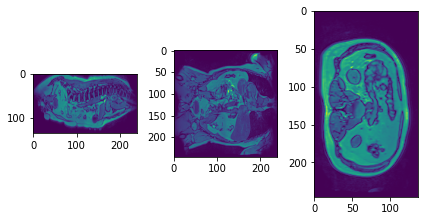

Affine:[[   2.            0.           -0.         -248.14639282]
 [   0.            2.           -0.         -148.68902588]
 [   0.            0.            3.         -719.81274414]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


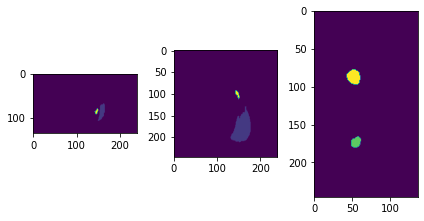

Saving Processed & Stitched Image.....
saving directory: temp/KORA/processed/volume
saving directory: temp/KORA/processed/label
KORA2456289
['datasets/lablmaps/KORA/KORA2456289/2456289_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm_rescaled_applied_in_bias_corrected_Adrenal gland(left).nrrd', 'datasets/lablmaps/KORA/KORA2456289/2456289_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm_rescaled_applied_in_bias_corrected_Kidney (Left).nrrd', 'datasets/lablmaps/KORA/KORA2456289/2456289_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm_rescaled_applied_in_bias_corrected_Kidney (Right).nrrd', 'datasets/lablmaps/KORA/KORA2456289/2456289_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm_rescaled_applied_in_bias_corrected_Spleen.nrrd', 'datasets/lablmaps/KORA/KORA2456289/2456289_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm_rescaled_applied_in_bias_corrected_Adrenal gland(right).nrrd', 'datasets/lablmaps/KORA/KORA2456289/2456289_t1_vibe_

Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/KORA/KORA2456289/2456289_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED_SPLEEN.NRRD
[False] False
LIVER DATASETS/LABLMAPS/KORA/KORA2456289/2456289_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED_SPLEEN.NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/KORA/KORA2456289/2456289_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED_SPLEEN.NRRD
SPL DATASETS/LABLMAPS/KORA/KORA2456289/2456289_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED_SPLEEN.NRRD
[True, True] True
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/KORA/KORA2456289/2456289_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED_ADRENALGLAND(RIGHT).NRRD
[F

Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/KORA/KORA2456289/2456289_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED_GALLBLADDER.NRRD
[False] False
LIVER DATASETS/LABLMAPS/KORA/KORA2456289/2456289_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED_GALLBLADDER.NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/KORA/KORA2456289/2456289_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED_GALLBLADDER.NRRD
SPL DATASETS/LABLMAPS/KORA/KORA2456289/2456289_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED_GALLBLADDER.NRRD
[False, False] False
KIDNEY_R DATASETS/LABLMAPS/KORA/KORA2456289/2456289_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED_GALLBLADDER.NRRD
KIDNEY(RIGHT) DATASETS/LABLMAPS/KORA/KORA2456289/2456289_T1_VIBE

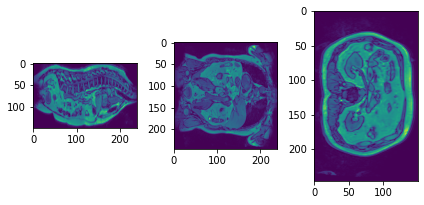

Affine:[[   2.            0.           -0.         -253.02911377]
 [   0.            2.           -0.         -152.5677948 ]
 [   0.            0.            3.         -734.99206543]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 150, 239)


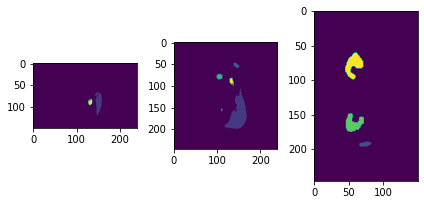

Saving Processed & Stitched Image.....
saving directory: temp/KORA/processed/volume
saving directory: temp/KORA/processed/label
KORA2453229
['datasets/lablmaps/KORA/KORA2453229/2453229_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm.nii_Gallbladder.nrrd', 'datasets/lablmaps/KORA/KORA2453229/2453229_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm.nii_Liver.nrrd', 'datasets/lablmaps/KORA/KORA2453229/2453229_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm.nii_Spleen.nrrd', 'datasets/lablmaps/KORA/KORA2453229/2453229_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm.nii_Adrenal gland(left).nrrd', 'datasets/lablmaps/KORA/KORA2453229/2453229_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm.nii_Kidney (left).nrrd', 'datasets/lablmaps/KORA/KORA2453229/2453229_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm.nii_Pancreas.nrrd', 'datasets/lablmaps/KORA/KORA2453229/2453229_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_si

Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/KORA/KORA2453229/2453229_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM.NII_KIDNEY(LEFT).NRRD
[False] False
LIVER DATASETS/LABLMAPS/KORA/KORA2453229/2453229_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM.NII_KIDNEY(LEFT).NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/KORA/KORA2453229/2453229_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM.NII_KIDNEY(LEFT).NRRD
SPL DATASETS/LABLMAPS/KORA/KORA2453229/2453229_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM.NII_KIDNEY(LEFT).NRRD
[False, False] False
KIDNEY_R DATASETS/LABLMAPS/KORA/KORA2453229/2453229_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM.NII_KIDNEY(LEFT).NRRD
KIDNEY(RIGHT) DATASETS/LABLMAPS/KORA/KORA2453229/2453229_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM.NII_KIDNEY(LEFT).NRRD
KIDNEY(RIGHT).NRRD DATASETS/LABLMAPS/KORA/KORA2453229/2453229_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_S

###############################################################################################
101 LIVER
###############################################################################################
102 SPLEEN
###############################################################################################
105 ADRENALGLAND
###############################################################################################
104 KIDNEY(LEFT)
###############################################################################################
103 KIDNEY(RIGHT)
###############################################################################################
105 ADRENALGLAND
###############################################################################################
106 PANCREAS
###############################################################################################
Overlapped Idxs Found, removing it for idx 0.0
im dim v:  (246, 150, 239)
segm dim v:  (246, 150, 164)
im spacing:  [2. 2. 3.]
se

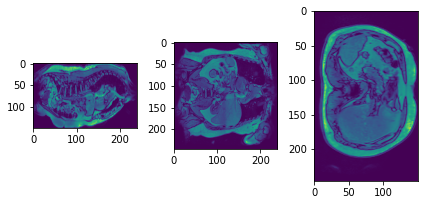

Affine:[[   2.            0.           -0.         -226.26609802]
 [   0.            2.           -0.         -145.30841064]
 [   0.            0.            3.         -712.81213379]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 150, 239)


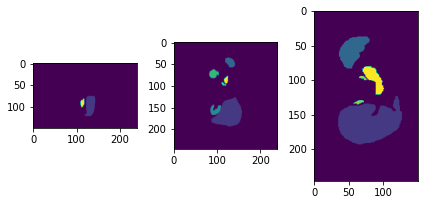

Saving Processed & Stitched Image.....
saving directory: temp/KORA/processed/volume
saving directory: temp/KORA/processed/label
KORA2453666
['datasets/lablmaps/KORA/KORA2453666/2453666_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm_rescaled_applied_in_bias_corrected_Kidney (right).nrrd', 'datasets/lablmaps/KORA/KORA2453666/2453666_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm_rescaled_applied_in_bias_corrected_Liver.nrrd', 'datasets/lablmaps/KORA/KORA2453666/2453666_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm_rescaled_applied_in_bias_corrected_Kidney (left).nrrd', 'datasets/lablmaps/KORA/KORA2453666/2453666_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm_rescaled_applied_in_bias_corrected_Adrenal gland(left).nrrd', 'datasets/lablmaps/KORA/KORA2453666/2453666_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm_rescaled_applied_in_bias_corrected_Gallbladder.nrrd', 'datasets/lablmaps/KORA/KORA2453666/2453666_t1_vibe_dixon_cor_

Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/KORA/KORA2453666/2453666_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED_GALLBLADDER.NRRD
[False] False
LIVER DATASETS/LABLMAPS/KORA/KORA2453666/2453666_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED_GALLBLADDER.NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/KORA/KORA2453666/2453666_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED_GALLBLADDER.NRRD
SPL DATASETS/LABLMAPS/KORA/KORA2453666/2453666_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED_GALLBLADDER.NRRD
[False, False] False
KIDNEY_R DATASETS/LABLMAPS/KORA/KORA2453666/2453666_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED_GALLBLADDER.NRRD
KIDNEY(RIGHT) DATASETS/LABLMAPS/KORA/KORA2453666/2453666_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_

Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/KORA/KORA2453666/2453666_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED_PANCREAS.NRRD
[False] False
LIVER DATASETS/LABLMAPS/KORA/KORA2453666/2453666_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED_PANCREAS.NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/KORA/KORA2453666/2453666_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED_PANCREAS.NRRD
SPL DATASETS/LABLMAPS/KORA/KORA2453666/2453666_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED_PANCREAS.NRRD
[False, False] False
KIDNEY_R DATASETS/LABLMAPS/KORA/KORA2453666/2453666_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED_PANCREAS.NRRD
KIDNEY(RIGHT) DATASETS/LABLMAPS/KORA/KORA2453666/2453666_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCA

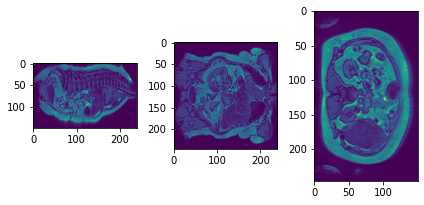

Affine:[[   2.            0.           -0.         -248.14639282]
 [   0.            2.           -0.         -147.78381348]
 [   0.            0.            3.         -724.9473877 ]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 150, 239)


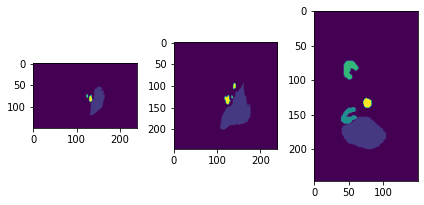

Saving Processed & Stitched Image.....
saving directory: temp/KORA/processed/volume
saving directory: temp/KORA/processed/label
KORA2453578
['datasets/lablmaps/KORA/KORA2453578/2453578_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm_rescaled_applied_in_bias_corrected.nii_Kidney (right) -3.nrrd', 'datasets/lablmaps/KORA/KORA2453578/2453578_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm_rescaled_applied_in_bias_corrected.nii_Liver-2.nrrd', 'datasets/lablmaps/KORA/KORA2453578/2453578_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm_rescaled_applied_in_bias_corrected.nii_Adrenal gland (left)-3.nrrd', 'datasets/lablmaps/KORA/KORA2453578/2453578_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm_rescaled_applied_in_bias_corrected.nii_Kidney (left) -3.nrrd', 'datasets/lablmaps/KORA/KORA2453578/2453578_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm_rescaled_applied_in_bias_corrected.nii_Adrenal gland (right)-3.nrrd', 'datasets/lablmaps/

Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/KORA/KORA2453578/2453578_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED.NII_GALLBLADDER-3.NRRD
[False] False
LIVER DATASETS/LABLMAPS/KORA/KORA2453578/2453578_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED.NII_GALLBLADDER-3.NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/KORA/KORA2453578/2453578_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED.NII_GALLBLADDER-3.NRRD
SPL DATASETS/LABLMAPS/KORA/KORA2453578/2453578_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED.NII_GALLBLADDER-3.NRRD
[False, False] False
KIDNEY_R DATASETS/LABLMAPS/KORA/KORA2453578/2453578_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED.NII_GALLBLADDER-3.NRRD
KIDNEY(RIGHT) DATASETS/LABLMAPS/KORA/KORA2453578/2453578_T1_VIBE_DIXON_COR_CA

###############################################################################################
101 LIVER
###############################################################################################
105 ADRENALGLAND
###############################################################################################
104 KIDNEY(LEFT)
###############################################################################################
105 ADRENALGLAND
###############################################################################################
107 GALLBLADDER
###############################################################################################
102 SPLEEN
###############################################################################################
106 PANCREAS
###############################################################################################
Overlapped Idxs Found, removing it for idx 0.0
im dim v:  (246, 137, 239)
segm dim v:  (246, 137, 164)
im spacing:  [2. 2. 3.]
segm

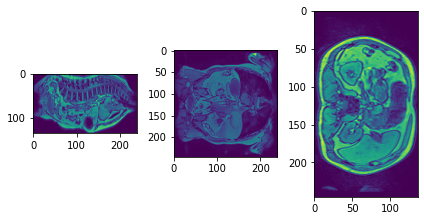

Affine:[[   2.            0.           -0.         -248.14639282]
 [   0.            2.           -0.         -141.38415527]
 [   0.            0.            3.         -759.14685059]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


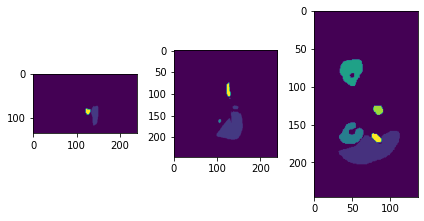

Saving Processed & Stitched Image.....
saving directory: temp/KORA/processed/volume
saving directory: temp/KORA/processed/label
KORA2459908
['datasets/lablmaps/KORA/KORA2459908/2459908_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-3_Pancreas.nrrd', 'datasets/lablmaps/KORA/KORA2459908/2459908_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-3_Adrenal gland(right).nrrd', 'datasets/lablmaps/KORA/KORA2459908/2459908_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-3_Adrenal gland(left).nrrd', 'datasets/lablmaps/KORA/KORA2459908/2459908_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-3_Liver-2.nrrd', 'datasets/lablmaps/KORA/KORA2459908/2459908_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-3_Kidney (right) .nrrd', 'datasets/lablmaps/KORA/KORA2459908/2459908_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-3_Gallbladder.nrrd', 'datasets/lablmaps/KORA/KORA2459908/2459908_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-3_Spleen.nrrd', 'datasets/lablmaps/KORA/KORA2459908/2459908_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-3_Kidney (left)

Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/KORA/KORA2459908/2459908_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_8-3_KIDNEY(RIGHT).NRRD
[False] False
LIVER DATASETS/LABLMAPS/KORA/KORA2459908/2459908_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_8-3_KIDNEY(RIGHT).NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/KORA/KORA2459908/2459908_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_8-3_KIDNEY(RIGHT).NRRD
SPL DATASETS/LABLMAPS/KORA/KORA2459908/2459908_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_8-3_KIDNEY(RIGHT).NRRD
[False, False] False
KIDNEY_R DATASETS/LABLMAPS/KORA/KORA2459908/2459908_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_8-3_KIDNEY(RIGHT).NRRD
KIDNEY(RIGHT) DATASETS/LABLMAPS/KORA/KORA2459908/2459908_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_8-3_KIDNEY(RIGHT).NRRD
KIDNEY(RIGHT).NRRD DATASETS/LABLMAPS/KORA/KORA2459908/2459908_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_8-3_KIDNEY(RIGHT).NRRD
KIDNEY(RECHTS) DATASETS/LABLMAPS/KORA/KORA2459908/2459908_T1_VIB

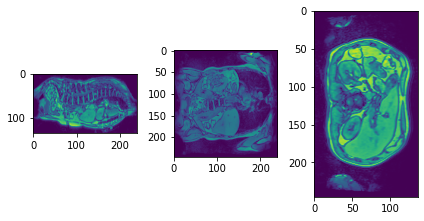

Affine:[[   2.            0.           -0.         -243.3011322 ]
 [   0.            2.           -0.         -163.25665283]
 [   0.            0.            3.         -729.90161133]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


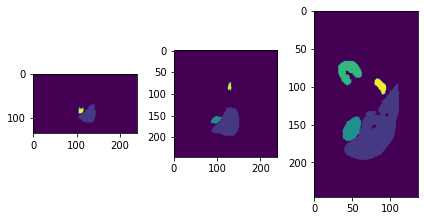

Saving Processed & Stitched Image.....
saving directory: temp/KORA/processed/volume
saving directory: temp/KORA/processed/label
KORA2460830
['datasets/lablmaps/KORA/KORA2460830/2460830_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_10_Pancreas.nrrd', 'datasets/lablmaps/KORA/KORA2460830/2460830_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_9_Kidney (right).nrrd', 'datasets/lablmaps/KORA/KORA2460830/2460830_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_9.nrrd_Adrenal gland(right).nrrd', 'datasets/lablmaps/KORA/KORA2460830/2460830_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_9_Gallbladder.nrrd', 'datasets/lablmaps/KORA/KORA2460830/2460830_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_9_Spleen.nrrd', 'datasets/lablmaps/KORA/KORA2460830/2460830_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_9.nii_Liver.nrrd', 'datasets/lablmaps/KORA/KORA2460830/2460830_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_9_Kidney (left).nrrd', 'datasets/lablmaps/KORA/KORA2460830/2460830_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_9-4.nrrd_Adrenal gland(left).n

Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/KORA/KORA2460830/2460830_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_9_SPLEEN.NRRD
[False] False
LIVER DATASETS/LABLMAPS/KORA/KORA2460830/2460830_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_9_SPLEEN.NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/KORA/KORA2460830/2460830_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_9_SPLEEN.NRRD
SPL DATASETS/LABLMAPS/KORA/KORA2460830/2460830_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_9_SPLEEN.NRRD
[True, True] True
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/KORA/KORA2460830/2460830_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_9.NII_LIVER.NRRD
[False] False
LIVER DATASETS/LABLMAPS/KORA/KORA2460830/2460830_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_9.NII_LIVER.NRRD
[True] True
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/KORA/KORA2460830/2460830_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_9_KIDNEY(LEFT).NRRD

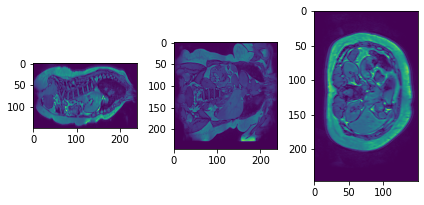

Affine:[[   2.            0.           -0.         -204.32450867]
 [   0.            2.           -0.         -162.29162598]
 [   0.            0.            3.         -712.89044189]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 150, 239)


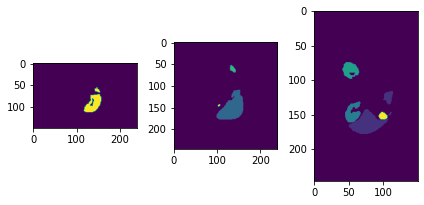

Saving Processed & Stitched Image.....
saving directory: temp/KORA/processed/volume
saving directory: temp/KORA/processed/label
KORA2460723
['datasets/lablmaps/KORA/KORA2460723/2460723_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-25.nrrd_Adrenal gland (left).nrrd', 'datasets/lablmaps/KORA/KORA2460723/2460723_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-26.nrrd_Pancreas.nrrd', 'datasets/lablmaps/KORA/KORA2460723/2460723_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8.nrrd_Adrenal gland(right).nrrd', 'datasets/lablmaps/KORA/KORA2460723/2460723_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Spleen.nrrd', 'datasets/lablmaps/KORA/KORA2460723/2460723_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Kidney (left).nrrd', 'datasets/lablmaps/KORA/KORA2460723/2460723_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8.nii_Liver.nrrd', 'datasets/lablmaps/KORA/KORA2460723/2460723_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Gallbladder.nrrd', 'datasets/lablmaps/KORA/KORA2460723/2460723_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Kidney(

Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/KORA/KORA2460723/2460723_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_8_KIDNEY(LEFT).NRRD
[False] False
LIVER DATASETS/LABLMAPS/KORA/KORA2460723/2460723_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_8_KIDNEY(LEFT).NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/KORA/KORA2460723/2460723_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_8_KIDNEY(LEFT).NRRD
SPL DATASETS/LABLMAPS/KORA/KORA2460723/2460723_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_8_KIDNEY(LEFT).NRRD
[False, False] False
KIDNEY_R DATASETS/LABLMAPS/KORA/KORA2460723/2460723_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_8_KIDNEY(LEFT).NRRD
KIDNEY(RIGHT) DATASETS/LABLMAPS/KORA/KORA2460723/2460723_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_8_KIDNEY(LEFT).NRRD
KIDNEY(RIGHT).NRRD DATASETS/LABLMAPS/KORA/KORA2460723/2460723_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_8_KIDNEY(LEFT).NRRD
KIDNEY(RECHTS) DATASETS/LABLMAPS/KORA/KORA2460723/2460723_T1_VIBE_DIXON_COR_CAIPI6_BH

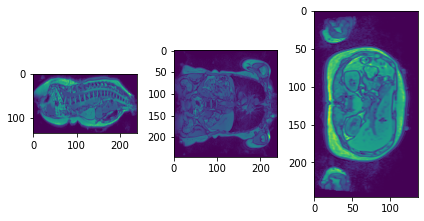

Affine:[[   2.            0.           -0.         -253.04954529]
 [   0.            2.           -0.         -160.82771301]
 [   0.            0.            3.         -681.3638916 ]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


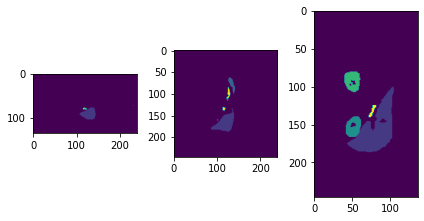

Saving Processed & Stitched Image.....
saving directory: temp/KORA/processed/volume
saving directory: temp/KORA/processed/label
FINISHED.


In [6]:
# exclude = ['KORA2460249', 'KORA2456120'] #, 'KORA2456120',  'KORA2462026']
# vol_to_check_list = None #['KORA2452879', 'KORA2456120']
print("STARTING KORA LABEL-MAPS.")
print('Reading Label Maps.....')
skip = True
for vol in file_paths.keys():
    print(vol)
    if (vol_to_check_list is not None and vol not in vol_to_check_list) or (vol == "") or (vol in exclude):
            continue
#     if vol == 'KORA2462026':
#         skip = False
#     if skip:
#         continue
    later = []
    print(file_paths[vol]['LABEL_PATHS'])
    if len(file_paths[vol]['LABEL_PATHS']) == 0:
        print(f"#################### ALERT:: NO LABELPATHS IN THE DICTIONARY FOR {vol} #########################")
        continue
    volume = nb.load(file_paths[vol]['N4_2']['OPP_CORRECTED'])
#     ref_vol = nb.load(file_paths[vol]['ONE_ORIG']['OPP'])
    img_ras_list = []
    for label_file_to_read in file_paths[vol]['LABEL_PATHS']:
        img_ras, lidx, labelname = read_ras(label_file_to_read, is_label=True)
        if img_ras is None:
            continue
        img_ras = makeit_3d(img_ras)
        if labelname in ['PANCREAS']:
            later.append([img_ras, lidx+LABEL_EXTENSION_FOR_OVERLAP_REMOVAL, labelname])
        else:
            img_ras_list.append([img_ras, lidx+LABEL_EXTENSION_FOR_OVERLAP_REMOVAL, labelname])
    
    img_ras_list.extend(later)
    
    s_label = kora_label_parts(img_ras_list)
    s_label = resample_to_output(s_label, TARGET_RESOLUTION, order=0, mode='constant', cval=0)
    s_label = drop_overlapped_pixels(s_label, np.array(img_ras_list)[:, 1])
    
    if vol == 'KORA2460249':
        volume, s_label = kora_vol_label_fix(volume, s_label, True)
    else:
        volume, s_label = kora_vol_label_fix(volume, s_label)
        
    volume = hist_match(volume)
    
    print('Viewing Stitched Images.....')
    volume_3_view_viewer(get_volume_data(volume))
    volume_3_view_viewer(get_volume_data(s_label))

    print('Saving Processed & Stitched Image.....')
    save_volume(volume, f'{processed_dir}/volume/{vol}')
    save_volume(s_label, f'{processed_dir}/label/{vol}')
    
print('FINISHED.')
